In [15]:
"""
Implementation of a simple multivalent binding model.
"""

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from src.MBmodel import cytBindingModel, SigData

In [19]:
def fitFunc(cons):
    "Runs least squares fitting for various model parameters, and returns the minimizers"
    x0 = np.array([-11, 0.5, 8.6, 8, 8.01, 7.6, 7, 7.01, 9.08, 8, 8.01, 8.59, 7, 7.01])  # KXSTAR, slopeT2, mIL4-IL4Ra, mIL4-Gamma, mIL4-IL13Ra, mNeo4-IL4Ra, mNeo4-Gamma, mNeo4-IL13Ra, hIL4-IL4Ra, hIL4-Gamma, hIL4-IL13Ra, hNeo4-IL4Ra, hNeo4-Gamma, hNeo4-IL13Ra (Log 10)
    bnds = ((-14, -10), (0, 10), (4, 11), (4, 11), (4, 11), (4, 11), (4, 11), (4, 11), (4, 11), (4, 11), (4, 11), (4, 11), (4, 11), (4, 11))
    parampredicts = minimize(resids, x0, method="L-BFGS-B", bounds=bnds, options={"disp": 999})
    #parampredicts = minimize(resids, x0, method="trust-constr", bounds=bnds, options={"disp": 999}, constraints=cons)
    assert parampredicts.success
    return parampredicts.x

def resids(x, retDF=False):
    """"Returns residuals against signaling data"""
    masterSTAT = pd.DataFrame(columns={"Cell", "Ligand", "Concentration", "Animal", "Experimental", "Predicted"})
    Kx = x[0]
    relRecp = x[1]
    xPow = np.power(10, x)

    CplxDict = {"mIL4": [xPow[2], xPow[3], xPow[4]],
    "mNeo4": [xPow[5], xPow[6], xPow[7]],
    "hIL4": [xPow[8], xPow[9], xPow[10]],
    "hNeo4": [xPow[11], xPow[12], xPow[13]]}
    if retDF:
        SigDataFilt = SigData
    if not retDF:
        SigDataFilt = SigData.loc[(SigData.Cell != "Macrophage") | (SigData.Animal != "Human")]
    for cell in SigDataFilt.Cell.unique():
        for animal in SigDataFilt.loc[SigData.Cell == cell].Animal.unique():
            for ligand in SigDataFilt.loc[(SigDataFilt.Cell == cell) & (SigDataFilt.Animal == animal)].Ligand.unique():
                isoData = SigDataFilt.loc[(SigDataFilt.Cell == cell) & (SigDataFilt.Animal == animal) & (SigDataFilt.Ligand == ligand)]
                Concs = isoData.Concentration.values
                normSigs = isoData.Signal.values
                ligCplx = CplxDict[ligand]
                if animal == "Human":
                    results = cytBindingModel(Kx, ligCplx, Concs, cell, animal, relRecp)
                else:
                    results = cytBindingModel(Kx, ligCplx, Concs, cell, animal, relRecp)
                masterSTAT = masterSTAT.append(pd.DataFrame({"Cell": cell, "Ligand": ligand, "Concentration": Concs, "Animal": animal, "Experimental": normSigs, "Predicted": results}))
            
            # Normalize
            masterSTAT.loc[(masterSTAT.Cell == cell) & (masterSTAT.Animal == animal), "Predicted"] /= masterSTAT.loc[(masterSTAT.Cell == cell) & (masterSTAT.Animal == animal)].Predicted.max()
            masterSTAT.loc[(masterSTAT.Cell == cell) & (masterSTAT.Animal == animal), "Experimental"] /= masterSTAT.loc[(masterSTAT.Cell == cell) & (masterSTAT.Animal == animal)].Experimental.max()
    
    masterSTAT = masterSTAT.fillna(0)
    masterSTAT.replace([np.inf, -np.inf], 0, inplace=True)

    if retDF:
        return masterSTAT
    else:
        print(x)
        print(np.linalg.norm(masterSTAT.Predicted.values - masterSTAT.Experimental.values))
        return np.linalg.norm(masterSTAT.Predicted.values - masterSTAT.Experimental.values)

In [20]:
def constraint1(x):
    return x[2]-x[3]
con1 = {'type': 'ineq', 'fun': constraint1}

def constraint2(x):
    return x[4]-x[3]
con2 = {'type': 'ineq', 'fun': constraint2}

def constraint3(x):
    return x[5]-x[6]
con3 = {'type': 'ineq', 'fun': constraint3}

def constraint4(x):
    return x[7]-x[6]
con4 = {'type': 'ineq', 'fun': constraint4}

def constraint5(x):
    return x[8]-x[9]
con5 = {'type': 'ineq', 'fun': constraint5}

def constraint6(x):
    return x[10]-x[9]
con6 = {'type': 'ineq', 'fun': constraint6}

def constraint7(x):
    return x[11]-x[12]
con7 = {'type': 'ineq', 'fun': constraint7}

def constraint8(x):
    return x[13]-x[12]
con8 = {'type': 'ineq', 'fun': constraint8}

constrnts = [con1, con2, con3, con4, con5, con6, con7, con8]

In [18]:
xOpt = fitFunc(constrnts)

         Cell Ligand  Concentration Animal     Signal
0       Ramos   hIL4      -14.22470  Human  -0.417190
1       Ramos   hIL4      -13.32160  Human  -0.409180
2       Ramos   hIL4      -12.41850  Human   0.421297
3       Ramos   hIL4      -11.51540  Human  14.410650
4       Ramos   hIL4      -10.61240  Human  74.506290
..        ...    ...            ...    ...        ...
749  Monocyte  hNeo4       -8.40824  Human  79.865327
750  Monocyte  hNeo4       -7.80618  Human  85.169141
751  Monocyte  hNeo4       -7.20412  Human  93.564539
752  Monocyte  hNeo4       -6.60206  Human  96.576495
753  Monocyte  hNeo4       -6.00000  Human  93.706481

[754 rows x 5 columns]
[-11.     0.5    8.6    8.     8.01   7.6    7.     7.01   9.08   8.
   8.01   8.59   7.     7.01]
7.107747498708333
         Cell Ligand  Concentration Animal     Signal
0       Ramos   hIL4      -14.22470  Human  -0.417190
1       Ramos   hIL4      -13.32160  Human  -0.409180
2       Ramos   hIL4      -12.41850  Human   0.42

KeyboardInterrupt: 

         Cell Ligand  Concentration Animal     Signal
0       Ramos   hIL4      -14.22470  Human  -0.417190
1       Ramos   hIL4      -13.32160  Human  -0.409180
2       Ramos   hIL4      -12.41850  Human   0.421297
3       Ramos   hIL4      -11.51540  Human  14.410650
4       Ramos   hIL4      -10.61240  Human  74.506290
..        ...    ...            ...    ...        ...
749  Monocyte  hNeo4       -8.40824  Human  79.865327
750  Monocyte  hNeo4       -7.80618  Human  85.169141
751  Monocyte  hNeo4       -7.20412  Human  93.564539
752  Monocyte  hNeo4       -6.60206  Human  96.576495
753  Monocyte  hNeo4       -6.00000  Human  93.706481

[754 rows x 5 columns]


(-0.1, 1.0)

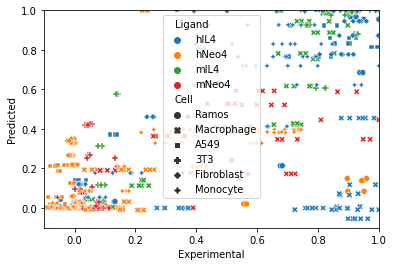

In [11]:
xOpt = [-10.14244904, 2.51923822, 8.65801158, 6.78733813, 7.88115742, 6.5803441, 5.90301747, 6.25269995, 9.67784511, 6.00654716, 8.34004633, 8.85765458, 4.8597555, 5.8816098]
modelDF = resids(xOpt, True)
sns.scatterplot(data=modelDF, x="Experimental", y="Predicted", hue="Ligand", style="Cell")
plt.xlim(-.1, 1)
plt.ylim(-.1, 1)

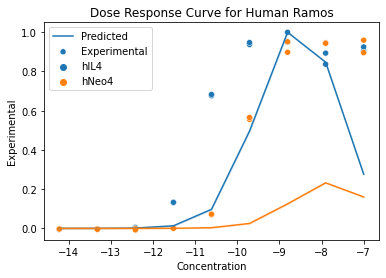

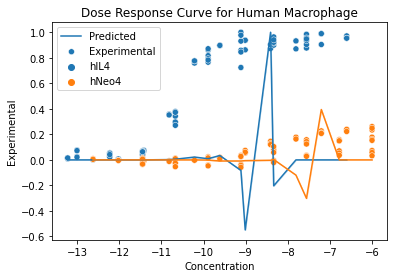

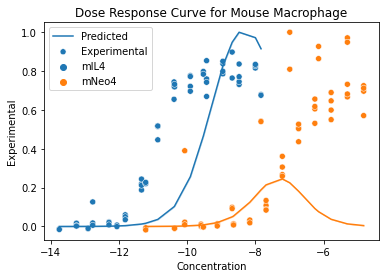

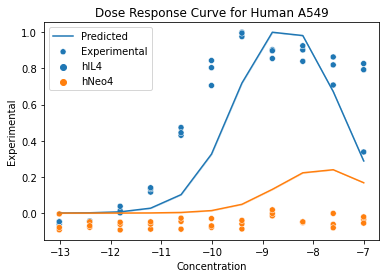

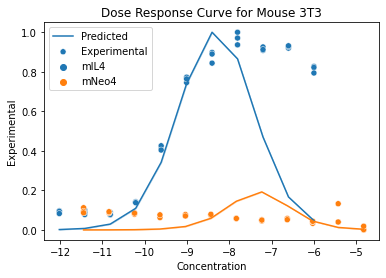

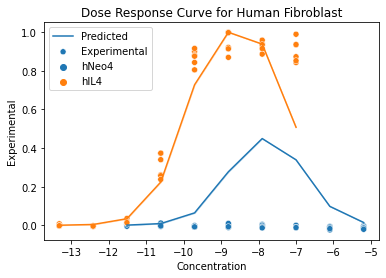

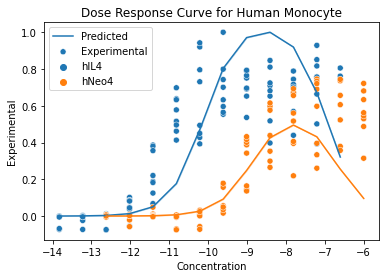

In [61]:
for cell in modelDF.Cell.unique():
    for animal in modelDF.loc[modelDF.Cell == cell].Animal.unique():
        isoData = modelDF.loc[(modelDF.Cell == cell) & (modelDF.Animal == animal)]
        fig, ax = plt.subplots()
        sns.scatterplot(data=isoData, x="Concentration", y="Experimental", label="Experimental", hue="Ligand")
        sns.lineplot(data=isoData, x="Concentration", y="Predicted", label="Predicted", hue="Ligand")
        ax.set_title("Dose Response Curve for " + animal + " " + cell)
        handles, labels = ax.get_legend_handles_labels()
        ax.legend([handles[0]] + handles[4::], [labels[0]] + labels[4::])